In [7]:
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory

batch_size = 16
# image_size = (224, 224)  # Resize all images to 224x224 (you can adjust this)

dataset_path = 'data/train'
train_dataset = image_dataset_from_directory(
    dataset_path,
    labels='inferred',
    label_mode='int',  # Default integer labels
    # image_size=image_size,
    batch_size=batch_size,
    shuffle=True,
    seed=123
)

dataset_path = 'data/test'
val_dataset = image_dataset_from_directory(
    dataset_path,
    labels='inferred',
    label_mode='int',  # Default integer labels
    # image_size=image_size,
    batch_size=batch_size,
    shuffle=True,
    seed=123
)

# Normalize pixel values to [0, 1]
normalization_layer = tf.keras.layers.Rescaling(1./255)

train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
val_dataset = val_dataset.map(lambda x, y: (normalization_layer(x), y))

# Prefetch data for better performance
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

# Print information
print(f"Train dataset batches: {len(train_dataset)}")
print(f"Validation dataset batches: {len(val_dataset)}")

Found 16110 files belonging to 9 classes.
Found 7713 files belonging to 9 classes.
Train dataset batches: 1007
Validation dataset batches: 483


In [8]:
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import image_dataset_from_directory

# Parameters
num_classes = 9  # Update based on your dataset
# image_size = (224, 224)
batch_size = 32

dataset_path = 'data/train'
train_dataset = image_dataset_from_directory(
    dataset_path,
    labels='inferred',
    label_mode='int',  # Default integer labels
    # image_size=image_size,
    batch_size=batch_size,
    shuffle=True,
    seed=123
)

dataset_path = 'data/test'
val_dataset = image_dataset_from_directory(
    dataset_path,
    labels='inferred',
    label_mode='int',  # Default integer labels
    # image_size=image_size,
    batch_size=batch_size,
    shuffle=True,
    seed=123
)


# Normalize pixel values and one-hot encode labels
normalization_layer = tf.keras.layers.Rescaling(1./255)

def preprocess(x, y):
    # x = normalization_layer(x)
    
    # print(x[0][0][0][0])
    y = tf.one_hot(y, depth=num_classes)  # One-hot encode labels
    return x, y

train_dataset = train_dataset.map(preprocess)
val_dataset = val_dataset.map(preprocess)

# Prefetch data for better performance
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

# Load the VGG19 model
base_model = VGG19(weights='imagenet', include_top=False)#, input_shape=(224, 224, 3))

# Freeze the base model
base_model.trainable = False

# Add custom classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
# x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
# x = Dropout(0.5)(x)
output = Dense(num_classes, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Found 16110 files belonging to 9 classes.
Found 7713 files belonging to 9 classes.


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, None, None, 64) │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, None, None, 64) │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, None, None,     │        73,856 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, None, None,     │       147,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, None, None,     │       295,168 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, None, None,     │     1,180,160 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │             

 Total params: 20,189,769 (77.02 MB)

 Trainable params: 165,385 (646.04 KB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [9]:
# Train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10  # Adjust as needed
)

Epoch 1/10
504/504 ━━━━━━━━━━━━━━━━━━━━ 91s 161ms/step - accuracy: 0.3973 - loss: 2.0561 - val_accuracy: 0.4291 - val_loss: 1.9136
Epoch 2/10
504/504 ━━━━━━━━━━━━━━━━━━━━ 76s 151ms/step - accuracy: 0.8307 - loss: 0.5554 - val_accuracy: 0.5027 - val_loss: 1.7504
Epoch 3/10
504/504 ━━━━━━━━━━━━━━━━━━━━ 75s 149ms/step - accuracy: 0.9103 - loss: 0.3031 - val_accuracy: 0.5260 - val_loss: 1.7674
Epoch 4/10
504/504 ━━━━━━━━━━━━━━━━━━━━ 75s 150ms/step - accuracy: 0.9520 - loss: 0.1894 - val_accuracy: 0.5462 - val_loss: 1.7982
Epoch 5/10
504/504 ━━━━━━━━━━━━━━━━━━━━ 75s 149ms/step - accuracy: 0.9700 - loss: 0.1272 - val_accuracy: 0.5508 - val_loss: 1.8142
Epoch 6/10
504/504 ━━━━━━━━━━━━━━━━━━━━ 75s 149ms/step - accuracy: 0.9794 - loss: 0.0926 - val_accuracy: 0.5574 - val_loss: 1.8574
Epoch 7/10
504/504 ━━━━━━━━━━━━━━━━━━━━ 75s 150ms/step - accuracy: 0.9882 - loss: 0.0650 - val_accuracy: 0.5633 - val_loss: 1.9409
Epoch 8/10
504/504 ━━━━━━━━━━━━━━━━━━━━ 76s 151ms/step - accuracy: 0.9919 - loss: 0

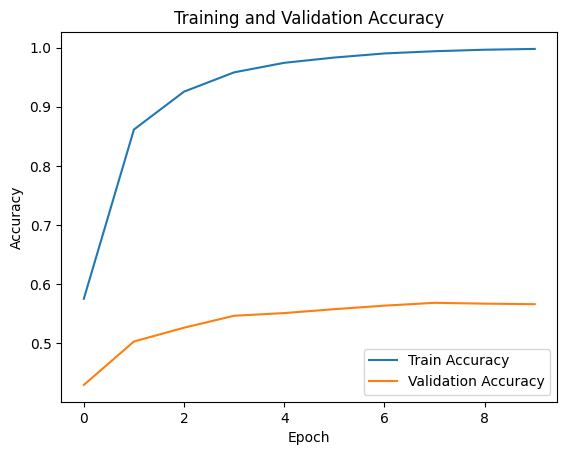

242/242 ━━━━━━━━━━━━━━━━━━━━ 25s 101ms/step - accuracy: 0.5592 - loss: 2.1322
Test Accuracy: 0.57


In [10]:
# Plot training and validation accuracy
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

# Evaluate on test data
test_loss, test_accuracy = model.evaluate(val_dataset)
print(f"Test Accuracy: {test_accuracy:.2f}")


In [11]:
! conda install scikit-learn -y

Channels:
 - conda-forge
 - defaults
Platform: linux-64
Solving environment: done

# All requested packages already installed.



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━

2025-01-24 12:28:10.156269: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


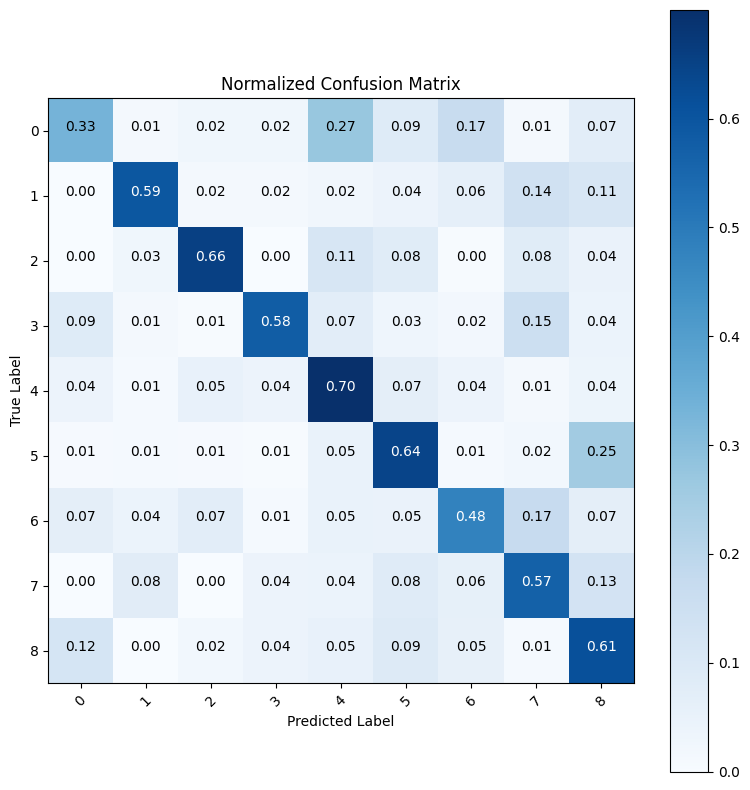

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Étape 1 : Obtenir les prédictions
true_labels = []
predicted_labels = []

# Parcourez le dataset de validation
for images, labels in val_dataset:
    # Prédictions
    predictions = model.predict(images)
    predicted_classes = np.argmax(predictions, axis=1)  # Classes prédites
    
    # Ajoutez les vraies étiquettes et prédictions
    true_labels.extend(np.argmax(labels.numpy(), axis=1))  # Convertir one-hot en index
    predicted_labels.extend(predicted_classes)

# Step 2: Create the Confusion Matrix
num_classes = len(np.unique(true_labels))
confusion_matrix = np.zeros((num_classes, num_classes), dtype=np.int32)

for t, p in zip(true_labels, predicted_labels):
    confusion_matrix[t, p] += 1


# Step 3: Normalize the Confusion Matrix
# Normalize by dividing each row by the number of instances in the true class
confusion_matrix_normalized = confusion_matrix.astype('float32')
for i in range(num_classes):
    confusion_matrix_normalized[i] /= np.sum(confusion_matrix[i])

# Step 4: Display the Normalized Confusion Matrix
plt.figure(figsize=(8, 8))
plt.imshow(confusion_matrix_normalized, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Normalized Confusion Matrix")
plt.colorbar()

# Add labels
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, tick_marks, rotation=45)
plt.yticks(tick_marks, tick_marks)

# Add counts to each cell (proportions)
threshold = confusion_matrix_normalized.max() / 2.
for i in range(num_classes):
    for j in range(num_classes):
        plt.text(j, i, format(confusion_matrix_normalized[i, j], '.2f'),
                 horizontalalignment="center",
                 color="white" if confusion_matrix_normalized[i, j] > threshold else "black")

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()
